In [16]:
from paths import *
from utils import *

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style='ticks', palette='Set2')

In [44]:
# Read original vignettes
vignettes15 = parse_vignettes_2015(RAW/'vignettes-2015.txt')
vignettes20 = parse_vignettes_2020(RAW/'vignettes-2020.tsv').reset_index(drop=True)

# Read the graded vignettes
vignettes15_graded = pd.read_excel(PROCESSED/'vignettes_diagnosis_predictions_instruct_graded.xlsx',
                                   sheet_name=0)
vignettes20_graded = pd.read_excel(PROCESSED/'vignettes_diagnosis_predictions_instruct_graded.xlsx',
                                   sheet_name=1)

def preprocess(vignettes_graded: pd.DataFrame) -> pd.DataFrame:
    
    # Remove NA columns added by excel 
    num_null_percol = vignettes_graded.isna().sum(axis=0)
    num_rows = vignettes_graded.shape[0]
    vignettes_graded = vignettes_graded.loc[:, num_null_percol < num_rows]
    
    # Remove NA rows added by excel
    num_null_perrow = vignettes_graded.isna().sum(axis=1)
    num_columns = vignettes_graded.shape[1]
    vignettes_graded = vignettes_graded.loc[num_null_perrow < num_columns]
    
    # Drop null value rows, getting rid of multiple prediction rows
    vignettes_graded = vignettes_graded.dropna().reset_index(drop=True)
    
    vignettes_graded.drop(["Number of predictions", "Top Predicted Dx", "Top-3 Predicted Dx"], 
                          inplace=True, axis=1)
    
    return vignettes_graded
    
vignettes15_graded = preprocess(vignettes15_graded)
vignettes20_graded = preprocess(vignettes20_graded)

# Vignettes 2015

In [45]:
print("Accuracy (Top-1):", vignettes15_graded['Top Dx Correct?'].value_counts()['Yes'] / vignettes15_graded.shape[0])
print("Accuracy (Top-3):", vignettes15_graded['Correct Dx in Top-3?'].value_counts()['Yes'] / vignettes15_graded.shape[0])

Accuracy (Top-1): 0.7555555555555555
Accuracy (Top-3): 0.9555555555555556


In [46]:
# Add triage info to graded vignettes
# Insert missing full stops
vignettes15_graded['Vignette'] = vignettes15_graded['Vignette'].map(lambda s: s if s.endswith('.') else (s + '.'))

# Malformed characterss
vignettes15_graded['Vignette'] = vignettes15_graded['Vignette'].str.replace("Â", "")
vignettes15_graded['Vignette'] = vignettes15_graded['Vignette'].str.replace("â€™", "’")
vignettes15_graded['Vignette'] = vignettes15_graded['Vignette'].str.replace("â€“", "–")

# Add triage info
vignettes15_graded = vignettes15_graded.merge(
    vignettes15[['Problem', 'Correct Triage']],
    left_on='Vignette',
    right_on='Problem',
    how='inner').reset_index(drop=True)
assert vignettes15_graded.shape[0] == vignettes15.shape[0]

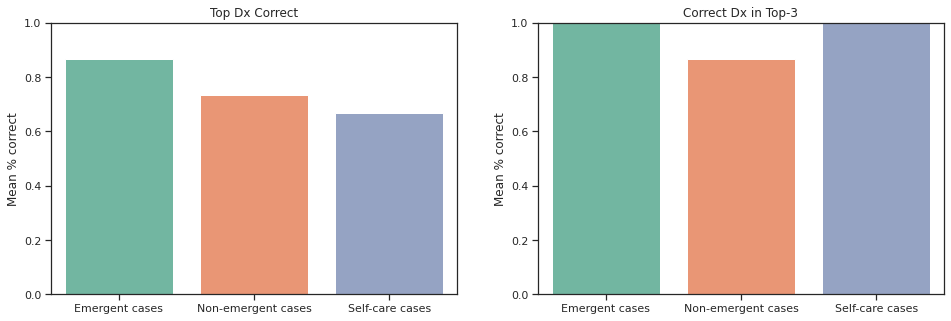

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

for col, ax in zip(['Top Dx Correct?', 'Correct Dx in Top-3?'], axes):
    df = vignettes15_graded.groupby('Correct Triage')[col].agg(lambda s: (s=='Yes').mean())
    df = df.loc[['Emergent', 'Non-emergent', 'Self-care']]
    df.index = [(col + ' cases') for col in list(df.index)]
    sns.barplot(x=df.index, y=df.values, ax=ax, )
    ax.set_ylim((0,1))
    ax.set_title(col[:-1])
    ax.set_ylabel('Mean % correct')

# Vignettes 2020

In [7]:
print("Accuracy (Top-1):", vignettes20_graded['Top Dx Correct?'].value_counts()['Yes'] / vignettes20_graded.shape[0])
print("Accuracy (Top-3):", vignettes20_graded['Correct Dx in Top-3?'].value_counts()['Yes'] / vignettes20_graded.shape[0])

Accuracy (Top-1): 0.6458333333333334
Accuracy (Top-3): 0.875


In [8]:
# Add triage info to graded vignettes
# Insert missing full stops
vignettes20_graded['Additional Details'] = vignettes20_graded['Additional Details'].map(lambda s: s if s.endswith('.') else (s + '.'))

# Add triage info
vignettes20_graded = vignettes20_graded.merge(
    vignettes20[['Additional Details', 'Correct Triage']],
    on=['Additional Details'],
    how='inner').reset_index(drop=True)
assert vignettes20_graded.shape[0] == vignettes20.shape[0]

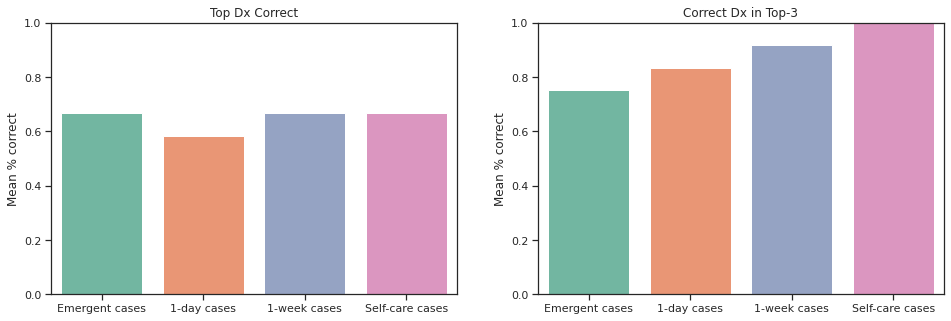

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))

for col, ax in zip(['Top Dx Correct?', 'Correct Dx in Top-3?'], axes):
    df = vignettes20_graded.groupby('Correct Triage')[col].agg(lambda s: (s=='Yes').mean())
    df = df.loc[['Emergent', '1-day', '1-week', 'Self-care']]
    df.index = [(col + ' cases') for col in list(df.index)]
    sns.barplot(x=df.index, y=df.values, ax=ax, )
    ax.set_ylim((0,1))
    ax.set_title(col[:-1])
    ax.set_ylabel('Mean % correct')